## 오토인코더 28*28

Epoch:1/20 Error:358440.54850508005
Epoch:5/20 Error:191349.05169523397
Epoch:9/20 Error:163775.63136107274
Epoch:13/20 Error:151780.53359629362
Epoch:17/20 Error:142143.29273260146


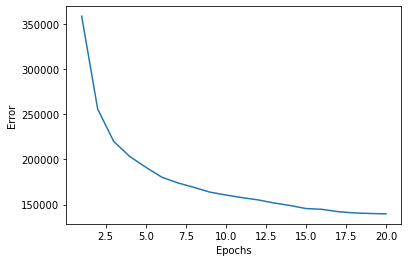

In [1]:
import numpy as np
# import cupy as np  # GPU를 사용하면 주석 해제
import matplotlib.pyplot as plt
from sklearn import datasets

from sklearn.model_selection import train_test_split
import tensorflow as tf

# -- 각 설정값 --
img_size = 28  # 이미지 크기와 폭
n_in_out = img_size * img_size  # 입출력층의 뉴런 수
n_mid = 64  # 은닉층 뉴런 수

eta = 0.001  # 학습률
epochs = 20 
batch_size = 32
interval = 4  # 경과 시간 표시 간격

# -- 훈련 데이터 생성 --
#digits_data = datasets.load_digits()
#x_train = np.asarray(digits_data.data)
#x_train /= 15  # # 범위는 0~1

mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## 이미지 데이터는 픽셀마다 0~255 사이의 값을 가짐.
## [데이터표준화] 255로 나누어 0~1 사이로 맞추는 것이 유리함.
train_images = train_images / 255
test_images = test_images / 255

# -- 입력 데이터 --
x_train = np.array(train_images)
x_train = x_train.reshape(-1, 784)
x_test = np.array(test_images)
x_test = x_test.reshape(-1, 784)

# -- 각 신경망층에서 상속할 입력층 -- --
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 은닉층 --
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)  # # He의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T) 

# -- 출력층 --
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # 시그모이드 함수

    def backward(self, t):
        delta = (self.y-t) * self.y * (1-self.y)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)      
        self.grad_x = np.dot(delta, self.w.T) 

# -- - 각 신경층의 초기화 --
middle_layer = MiddleLayer(n_in_out, n_mid)  # 인코더
output_layer = OutputLayer(n_mid, n_in_out)  # 디코더

# -- 순전파 --
def forward_propagation(x_mb):
    middle_layer.forward(x_mb)
    output_layer.forward(middle_layer.y)

# -- 역전파 --
def backpropagation(t_mb):
    output_layer.backward(t_mb)
    middle_layer.backward(output_layer.grad_x)

# -- 파라미터 갱신 --
def update_params():
    middle_layer.update(eta)
    output_layer.update(eta)

# -- 오차 계산 --
def get_error(y, t):
    return 1.0/2.0*np.sum(np.square(y - t))  # 오차 제곱합

error_record = []
n_batch = len(x_train) // batch_size  # # 1에포크당 배치 개수
for i in range(epochs):
        
    # -- 학습 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # # 인덱스 뒤섞기(셔플하기)
    for j in range(n_batch):
        
        # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        
        # 순전파와 역전파 함수 실행
        forward_propagation(x_mb)
        backpropagation(x_mb)
        
        # 가중치와 편향 업데이트
        update_params()

    # -- - 오차 계산 ---
    forward_propagation(x_train)
    error = get_error(output_layer.y, x_train)
    error_record.append(error)

    # -- - 결과 확인 -- 
    if i%interval == 0:
        print("Epoch:"+str(i+1)+"/"+str(epochs), "Error:"+str(error))

plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 생성된 이미지 나타내기

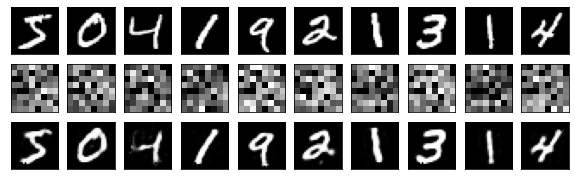

In [3]:
n_img = 10  #  보여줄 이미지 수
middle_layer.forward(x_train[:n_img])
output_layer.forward(middle_layer.y)

plt.figure(figsize=(10, 3))
for i in range(n_img):
    # 입력 이미지
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_train[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 은닉층에서 출력한 이미지
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(middle_layer.y[i].reshape(8, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 츌력 이미지
    ax = plt.subplot(3, n_img, i+1+2*n_img)
    plt.imshow(output_layer.y[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()